In [1]:
import os
import json
import dill
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.io import savemat
np.set_printoptions(precision=3)

In [2]:
sess_name = 'sims_4'
load_session = False

In [3]:
if load_session:
    dill.load_session('output/%s.pkl' % sess_name)

In [4]:
save_figs = False
save_session = False
save_mat = False
save_txt = False

In [5]:
with open('%s.json' % sess_name) as f:
    param_dict = json.load(f)
globals().update(param_dict)

In [6]:
np.random.seed(seed)

t = np.arange(0, t_max, t_step)
freqs = np.fft.fftfreq(len(t), t_step)
w = 2*np.pi*freqs

sigma_x = sigma_x_prop * abs(x_1 - x_2)
sigma_F = sigma_F_prop * f_dc

f_dc_w = f_dc * len(w)**0.5
sigma_x_hat = sigma_x
sigma_F_hat = sigma_F

In [7]:
def Sigma_red():
    w_ = w.copy()
    w_[0] = 1.0
    Sigma_red_ = np.abs(w_)**(-gamma)
    return Sigma_red_

    
def Sigma_phi(tau, alpha_1, alpha_2):
    w_ = w.copy()
    w_[0] = 1.0
    Sigma_phi_ = (alpha_1**2 + alpha_2**2 + 2*alpha_1*alpha_2*np.cos(w*tau)) / (np.abs(w_)**gamma)
    return Sigma_phi_
    
    
def Sigma_F(tau, alpha_1, alpha_2):
    Sigma_phi_ = Sigma_phi(tau, alpha_1, alpha_2)
    Sigma_F_ = Sigma_phi_ + sigma_F_hat**2
    return Sigma_F_

In [8]:
def rand_psd(psd):
    N = len(psd)
    F_w = np.zeros((N,), dtype=np.complex64)
    F_w[1:1+N//2]  =    np.random.randn(N//2)*(psd[1:1+N//2]**0.5)/(2**0.5)
    F_w[1:1+N//2] += 1j*np.random.randn(N//2)*(psd[1:1+N//2]**0.5)/(2**0.5)
    F_w[(1+N)//2:] = np.flip(np.conj(F_w[1:1+N//2]))
    if N % 2 == 0:
        F_w[N//2] = 0
    return F_w

In [9]:
Sigma_eps_ = np.ones(w.shape)*sigma_F_hat**2
Sigma_red_ = Sigma_red()
eps_F_w = rand_psd(Sigma_eps_)
f_red_w = rand_psd(Sigma_red_)
eps_F_w[0] = np.random.randn(1)*sigma_F_hat
f_red_w[0] = f_dc_w

f1_w = alpha_1 * f_red_w
f2_w = alpha_2 * f_red_w * np.exp(1j*w*tau)
phi_w = f1_w + f2_w
phi_w[0] += alpha_0*len(w)
F_w = phi_w + eps_F_w

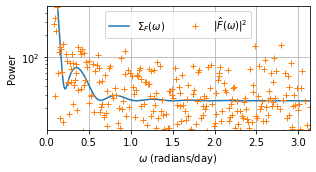

In [10]:
plt.figure(figsize=[4.5, 2.5])
Sigma_F_ = Sigma_F(tau, alpha_1, alpha_2)
plt.semilogy(w[1:len(freqs)//2], Sigma_F_[1:len(freqs)//2], 
             label=r'$\Sigma_F(\omega)$')
plt.semilogy(w[1:len(freqs)//2], np.abs(F_w[1:len(freqs)//2])**2, '+',
             label=r'$\left|\hat{F}(\omega)\right|^2$')
plt.ylabel('Power')
plt.xlabel(r'$\omega$ (radians/day)')
plt.ylim([Sigma_F_[len(freqs)//2]/2.5, Sigma_F_[15]])
plt.xlim([0, w[len(freqs)//2-1]])
plt.grid()
plt.legend(loc='upper center', ncol=2)
plt.tight_layout()

if save_figs:
    plt.savefig('figures/total_power_%s.pdf' % (sess_name))

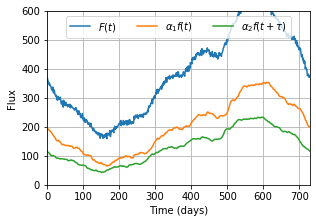

In [11]:
phi_t = np.real(ifft(phi_w[:], norm='ortho'))
F_t = np.real(ifft(F_w[:], norm='ortho'))
f1_t = np.real(ifft(f1_w[:], norm='ortho'))
f2_t = np.real(ifft(f2_w[:], norm='ortho'))

eps_x_t = np.random.randn(len(w)) * sigma_x
chi_t = (x_1 * f1_t + x_2 * f2_t) / phi_t
x_t = chi_t + eps_x_t

plt.figure(figsize=[4.5, 3.2])
plt.plot(t, F_t, label=r'$F(t)$')
plt.plot(t, f1_t, label=r'$\alpha_1 f(t)$')
plt.plot(t, f2_t, label=r'$\alpha_2 f(t+\tau)$')
plt.ylabel('Flux')
plt.xlabel('Time (days)')
plt.ylim([0, 600.])
plt.xlim([0, t[-1]])
plt.grid()
plt.legend(loc='upper center', ncol=3)
plt.tight_layout()

if save_figs:
    plt.savefig('figures/light_curves_%s.pdf' % (sess_name))

In [12]:
# build the forward and inverse DFT matrices
DFT = fft(np.eye(len(F_t)), norm='ortho', axis=0)
DFT_dagger = DFT.conj().T

In [13]:
def A_hat(tau, alpha_1, alpha_2):
    num_ = alpha_1*x_1 + alpha_2*x_2*np.exp(1j*w*tau)
    denom_ = alpha_1 + alpha_2*np.exp(1j*w*tau)
    A_hat_ = num_ / denom_
    return A_hat_


def x_of_F_w(F_w, tau, alpha_1, alpha_2):
    F_w_tilde = F_w.copy()
    F_w_tilde[0] -= alpha_0*len(w)    
    A_hat_ = A_hat(tau, alpha_1, alpha_2)
    F_t_ = np.real(ifft(F_w, norm='ortho'))
    x_t_ = np.real(ifft(A_hat_*F_w_tilde, norm='ortho')) / F_t_
    return x_t_

    
def X_hat_of_F_w(F_w, tau, alpha_1, alpha_2):
    X_t = np.diag(x_of_F_w(F_w, tau, alpha_1, alpha_2))
    X_hat_ = ((DFT @ X_t) @ DFT_dagger) * len(w)**-1  # TODO: check factor len(w)**-1
    return X_hat_


def mu_epsilon_F_given_F(F_w, tau, alpha_1, alpha_2):
    Sigma_phi_ = Sigma_phi(tau, alpha_1, alpha_2)
    shrink = sigma_F_hat**2 / (sigma_F_hat**2 + Sigma_phi_)
    mu_ = shrink * F_w
    return mu_


def mu_G_given_F(F_w, tau, alpha_1, alpha_2):
    mu_epsilon_F_given_F_ = mu_epsilon_F_given_F(F_w, tau, alpha_1, alpha_2)
    X_hat_ = X_hat_of_F_w(F_w, tau, alpha_1, alpha_2)    
    A_hat_ = A_hat(tau, alpha_1, alpha_2)    
    mu_ = A_hat_*F_w + (X_hat_ - np.diag(A_hat_)) @ mu_epsilon_F_given_F_
    return mu_

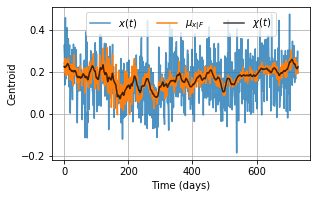

In [14]:
x_of_F_w_ = x_of_F_w(F_w, tau, alpha_1, alpha_2)

plt.figure(figsize=[4.5, 2.85])
plt.plot(x_t, alpha=0.8, label=r'$x(t)$')
plt.plot(x_of_F_w_, alpha=1, label=r'$\mu_{x|F}$')
plt.plot(chi_t, alpha=0.75, label=r'$\chi(t)$', color='black')
plt.xlabel('Time (days)')
plt.ylabel('Centroid')
plt.grid()
plt.legend(loc='upper center', ncol=3)
plt.tight_layout()

if save_figs:
    plt.savefig('figures/centroid_curves_%s.pdf' % (sess_name))

In [15]:
def Gamma_epsilon_F_given_F(tau, alpha_1, alpha_2):
    Sigma_phi_ = Sigma_phi(tau, alpha_1, alpha_2)
    Gamma_ = np.real(np.diag((sigma_F_hat**-2 + Sigma_phi_**-1)**-1))
    return Gamma_

    
def Gamma_G_given_F(F_w, tau, alpha_1, alpha_2):
    F_w_ = np.reshape(F_w, (-1, 1))
    X_hat_ = X_hat_of_F_w(F_w, tau, alpha_1, alpha_2)
    A_hat_ = A_hat(tau, alpha_1, alpha_2)
    X_minus_A = X_hat_ - np.diag(A_hat_)
    Gamma_epsilon_F_given_F_ = Gamma_epsilon_F_given_F(tau, alpha_1, alpha_2)
    Gamma_1_ = ((DFT @ np.diag(F_t**2)) @ DFT_dagger) * sigma_x_hat**2
    Gamma_2_ = (X_minus_A @ Gamma_epsilon_F_given_F_) @ np.conj(X_minus_A.T)
    Gamma_ = Gamma_1_ + Gamma_2_
    return Gamma_, Gamma_1_, Gamma_2_

/Users/ofer/Dropbox/Projects/time_delay/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


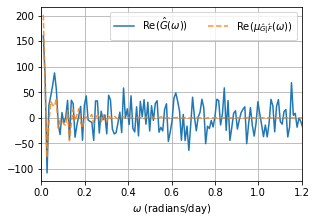

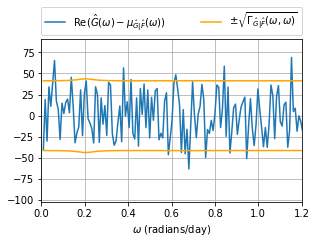

In [16]:
G_t = x_t*F_t
G_w = fft(G_t, norm='ortho')
mu_G_given_F_ = mu_G_given_F(F_w, tau, alpha_1, alpha_2)
A_hat_F_w_ = A_hat(tau, alpha_1, alpha_2) * F_w

plt.figure(figsize=[4.5, 3.2])
plt.plot(w[1:len(freqs)//2], np.real(G_w[1:len(freqs)//2]), '-',
         label=r'$\mathrm{Re}(\hat{G}(\omega))$', alpha=1.0)
plt.plot(w[1:len(freqs)//2], np.real(mu_G_given_F_[1:len(freqs)//2]), '--',
         label=r'$\mathrm{Re}(\mu_{\hat{G}|\hat{F}}(\omega))$', alpha=0.85)

plt.xlabel(r'$\omega$ (radians/day)')
plt.xlim([0, 1.2])
plt.grid()
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()

if save_figs:
    plt.savefig('figures/G_mu_G_%s.pdf' % (sess_name))

Gamma_G_given_F_, Gamma_1_, Gamma_2_ = Gamma_G_given_F(F_w, tau, alpha_1, alpha_2)

plt.figure(figsize=[4.5, 3.5])
plt.plot(w[1:len(w)//2], np.real((G_w-mu_G_given_F_)[1:len(w)//2]), 
         label=r'$\mathrm{Re}(\hat{G}(\omega) - \mu_{\hat{G}|\hat{F}}(\omega))$')
plt.plot(w[1:len(w)//2], np.diag(Gamma_G_given_F_)[1:len(w)//2]**0.5, color='orange', 
         label=r'$\pm\sqrt{\Gamma_{\hat{G}|\hat{F}}(\omega, \omega)}$')
plt.plot(w[1:len(w)//2], -np.diag(Gamma_G_given_F_)[1:len(w)//2]**0.5, color='orange')
plt.xlabel(r'$\omega$ (radians/day)')
plt.xlim([0, 1.2])
plt.grid()
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
plt.tight_layout()

if save_figs:
    plt.savefig('figures/G_Gamma_G_%s.pdf' % (sess_name))

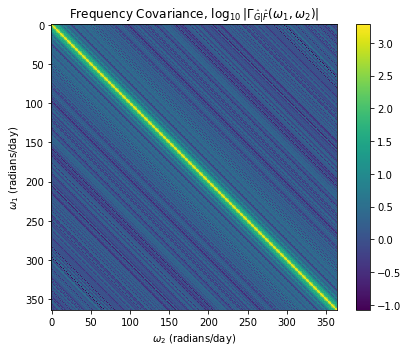

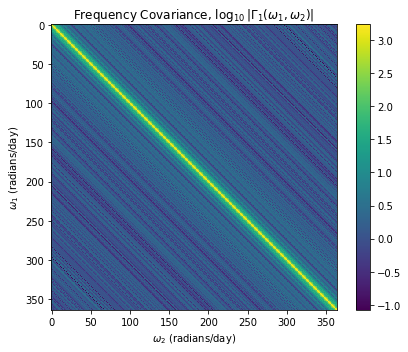

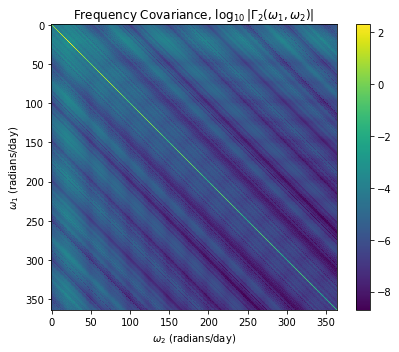

In [18]:
plt.figure(figsize=[6.2, 5])
plt.imshow(np.log10(np.abs(Gamma_G_given_F_[1:len(freqs)//2, 1:len(freqs)//2])))
plt.colorbar()
plt.ylabel(r'$\omega_1$ (radians/day)')
plt.xlabel(r'$\omega_2$ (radians/day)')
plt.title(r'Frequency Covariance, $\log_{10}\,\left| \Gamma_{\hat{G}|\hat{F}}(\omega_1, \omega_2)\right|$')
plt.tight_layout()

plt.figure(figsize=[6.2, 5])
plt.imshow(np.log10(np.abs(Gamma_1_[1:len(freqs)//2, 1:len(freqs)//2])))
plt.colorbar()
plt.ylabel(r'$\omega_1$ (radians/day)')
plt.xlabel(r'$\omega_2$ (radians/day)')
plt.title(r'Frequency Covariance, $\log_{10}\,\left| \Gamma_{1}(\omega_1, \omega_2)\right|$')
plt.tight_layout()

plt.figure(figsize=[6.2, 5])
plt.imshow(np.log10(np.abs(Gamma_2_[1:len(freqs)//2, 1:len(freqs)//2])))
plt.colorbar()
plt.ylabel(r'$\omega_1$ (radians/day)')
plt.xlabel(r'$\omega_2$ (radians/day)')
plt.title(r'Frequency Covariance, $\log_{10}\,\left| \Gamma_{2}(\omega_1, \omega_2)\right|$')
plt.tight_layout()

if save_figs:
    plt.savefig('figures/Gamma_G_%s.pdf' % (sess_name))

In [19]:
def log_like_F(F_w, tau, alpha_1, alpha_2):
    Sigma_F_ = Sigma_F(tau, alpha_1, alpha_2)[1:]
    power_F_ = (np.abs(F_w)**2)[1:]
    ll = -0.5*np.sum(power_F_ / Sigma_F_) -0.5*np.sum(np.log(2*np.pi*Sigma_F_))
    return ll


def log_like_G_given_F(G_w, F_w, tau, alpha_1, alpha_2):
    mu_G_given_F_ = mu_G_given_F(F_w, tau, alpha_1, alpha_2)
    G_minus_mu = (G_w - mu_G_given_F_)[1:]
    Gamma_G_given_F_ = Gamma_G_given_F(F_w, tau, alpha_1, alpha_2)[0][1:, 1:]
    inv_Gamma_G_given_F = np.linalg.inv(Gamma_G_given_F_)
    s, logdet = np.linalg.slogdet(np.pi*Gamma_G_given_F_)
    mahal = np.sum(np.conj(G_minus_mu) * (inv_Gamma_G_given_F @ G_minus_mu))
    ll = -np.real(logdet) - np.real(mahal)
    return ll

In [20]:
if not load_session:
    tau_ = np.linspace(tau*ll_tau_min_ratio, tau*ll_tau_max_ratio, ll_bins_i)
    alpha_2_ = np.linspace(alpha_2*ll_alpha_2_min_ratio, alpha_2*ll_alpha_2_max_ratio, ll_bins_j)

    ll_F = np.zeros((len(tau_), len(alpha_2_)))
    ll_G_given_F = np.zeros((len(tau_), len(alpha_2_)))
    for i, tau__ in enumerate(tau_):
        for j, alpha_2__ in enumerate(alpha_2_):
            ll_F[i, j] = log_like_F(F_w, tau__, alpha_1, alpha_2__)
            ll_G_given_F[i, j] = log_like_G_given_F(G_w, F_w, tau__, alpha_1, alpha_2__) 

In [21]:
from scipy.stats.distributions import chi2


def imshow_likelihood_confidence(x, y, l, ax, alpha=0.66, dfs=[2, 6], df_colors=['black', 'red']):
    
    extent = [x[0], x[-1], y[0], y[-1]]
    x_, y_ = np.meshgrid(x, y)
    
    l /= np.max(l)
    ll = np.log(l)
    
    for i, df in enumerate(dfs):
        levels = -0.5 * chi2.ppf([0.997, 0.95, 0.68], df)
        ax.contour(x_, y_, ll, levels, colors=df_colors[i])
        
    ax.imshow(l, extent=extent, origin='lower', clim=(0,1), alpha=alpha)
    ax.set_aspect(abs((extent[0]-extent[1])/(extent[2]-extent[3])))

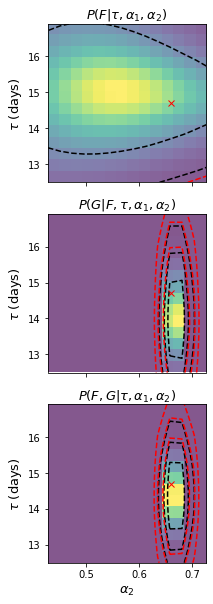

In [22]:
P_F = np.exp(ll_F-np.max(ll_F))
P_G_given_F = np.exp(ll_G_given_F-np.max(ll_G_given_F))
P_F_G = np.exp(ll_F + ll_G_given_F-np.max(ll_F + ll_G_given_F))

extent = [alpha_2_[0], alpha_2_[-1], tau_[0], tau_[-1]]
fig, axs = plt.subplots(3, 1, figsize=[3.5, 8.5])
imshow_likelihood_confidence(alpha_2_, tau_, P_F, axs[0])
axs[0].plot(alpha_2, tau, 'x', color='red')
axs[0].set_title(r'$P(F|\tau,\alpha_1,\alpha_2)$', fontsize=13)
imshow_likelihood_confidence(alpha_2_, tau_, P_G_given_F, axs[1])
axs[1].plot(alpha_2, tau, 'x', color='red')
axs[1].set_title(r'$P(G|F,\tau,\alpha_1,\alpha_2)$', fontsize=13)
imshow_likelihood_confidence(alpha_2_, tau_, P_F_G, axs[2])
axs[2].plot(alpha_2, tau, 'x', color='red')
axs[2].set_title(r'$P(F,G|\tau,\alpha_1,\alpha_2)$', fontsize=13)

for ax in axs.flat:
    ax.set_xlabel(r'$\alpha_2$', fontsize=13)
    ax.set_ylabel(r'$\tau$ (days)', fontsize=13)

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()
    ax.set_aspect(abs((extent[0]-extent[1])/(extent[2]-extent[3])))
    
plt.tight_layout()

if save_figs:
    plt.savefig('figures/P_%s.pdf' % (sess_name))

In [23]:
if save_session:
    del load_session
    dill.dump_session('output/%s.pkl' % sess_name)

In [24]:
# Compute some intermediate values for comparison
Sigma_phi_ = Sigma_phi(tau, alpha_1, alpha_2)
Sigma_F_ = Sigma_F(tau, alpha_1, alpha_2)
X_hat_ = X_hat_of_F_w(F_w, tau, alpha_1, alpha_2)
A_hat_ = A_hat(tau, alpha_1, alpha_2)
Gamma_epsilon_F_given_F_ = Gamma_epsilon_F_given_F(tau, alpha_1, alpha_2)

In [25]:
mdict = \
    {'t': t, 'freqs': freqs, 'w': w,
     'sigma_x': [sigma_x], 'sigma_F': [sigma_F],
     'f_dc_w': [f_dc_w], 'sigma_x_hat': [sigma_x_hat], 'sigma_F_hat': [sigma_F_hat],
     'Sigma_eps_': Sigma_eps_, 'Sigma_red_': Sigma_red_, 'eps_F_w': eps_F_w, 'f_red_w': f_red_w,
     'f1_w': f1_w, 'f2_w': f2_w, 'phi_w': phi_w, 'F_w': F_w,
     'phi_t': phi_t, 'F_t': F_t, 'f1_t': f1_t, 'f2_t': f2_t, 'eps_x_t': eps_x_t, 'chi_t': chi_t, 'x_t': x_t,
     'DFT': DFT, 'DFT_dagger': DFT_dagger,
     'G_t': G_t, 'G_w': G_w, 'mu_G_given_F_': mu_G_given_F_, 'A_hat_F_w_': A_hat_F_w_,
     'Gamma_G_given_F_': Gamma_G_given_F_, 
     'Sigma_phi_': Sigma_phi_, 'Sigma_F_': Sigma_F_, 'X_hat_': X_hat_, 'A_hat_': A_hat_, 
     'Gamma_epsilon_F_given_F_': Gamma_epsilon_F_given_F_,
     'tau_': tau_, 'alpha_2_': alpha_2_, 'll_F': ll_F, 'll_G_given_F': ll_G_given_F}

if save_mat:    
    savemat('output_mat/%s.mat' % sess_name, mdict)
    
if save_txt:
    os.mkdir('output_txt/%s' % sess_name)
    for k in mdict.keys():
        np.savetxt('output_txt/%s/%s.txt' % (sess_name, k), mdict[k])